# Heart rate prediction Neural Network

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## Parameters

In [109]:
# !! Change neural network layers further down in model definition

SHUFFLE_TRAIN_DATA = True
BATCH_SIZE = 16

MAX_EPOCHS = 250
MIN_EPOCHS = 20
SIMILAR_LOSS_EPOCHS_BEFORE_STOPPING = 10

LEARNING_RATE = 0.001
# OPTIMISER MOVED TO MODEL DEFINITION

# DON'T CHANGE BETWEEN TESTING
K_FOLDS = 5
TEST_SPLIT = 0.05

## Prepare model Archiving

In [110]:
# Prepare data folder for archiving
import os

# Ensure that we have a folder for the model archives
MODELS_FOLDER = "model_archive"
os.makedirs(MODELS_FOLDER, exist_ok=True)

# Find current model iteration by looking at the folders in the current directory
CURRENT_MODEL_ITERATION = len([name for name in os.listdir(os.path.join('.', 'model_archive'))])

# Create folder for current model iteration
ITERATION_FOLDER = os.path.join(MODELS_FOLDER, "model_kfold_{}".format(CURRENT_MODEL_ITERATION))
os.mkdir(ITERATION_FOLDER)

## Import and prepare data

In [111]:
# Import data
df = pd.read_csv('../data/combined_dataframe.csv')

# Drop irrelevant columns
df = df.drop(['START_TIME', 'END_TIME'], axis=1)

# Convert bools to ints in every column that has bools
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

df.head(5)

,TAG_LECTURE,TAG_MEETING,TAG_WORKOUT,TAG_VOLLEYBAL,TAG_PARTY,TAG_TUTOR,TAG_HAIRCUT,TAG_SELFSTUDY,TAG_PROMOCIE,TAG_COOKING,...,TAG_CALLING,TAG_HIGHSCHOOLFRIENDS,DURATION,DAY_OF_WEEK,HOUR_OF_DAY,EVENTS_PER_DAY,HRT_AVG,HRT_MED,HRT_10,HRT_90
0,1,0,0,0,0,0,0,0,0,0,...,0,0,240,1,8,4,83.152174,80.0,70.9,99.2
1,1,1,0,0,0,0,0,0,0,0,...,0,0,240,2,8,6,91.588496,90.0,76.0,113.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,120,2,13,6,85.271930,83.0,73.3,99.7
3,1,1,0,0,0,0,0,0,0,0,...,0,0,240,3,13,5,80.308696,78.0,70.0,95.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,120,4,8,5,81.615385,79.0,71.3,95.4


In [112]:
np.random.seed(42)

target_headers = ["HRT_AVG", "HRT_MED", "HRT_10", "HRT_90"]
X = df.drop(target_headers, axis=1)
y = df[target_headers]

# Normalize target data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y)

# Split train, test before k-folding
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=42)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

# Create folds for k-fold cross validation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=K_FOLDS, shuffle=SHUFFLE_TRAIN_DATA)

# X_train = tf.convert_to_tensor(X_train)
# y_train = tf.convert_to_tensor(y_train)
# X_val = tf.convert_to_tensor(X_val)
# y_val = tf.convert_to_tensor(y_val)
# X_test = tf.convert_to_tensor(X_test)
# y_test = tf.convert_to_tensor(y_test)


## NN model

### Model Callbacks

In [113]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mean error callback 
train_mse = []
val_mse = []
class MeanErrorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_mse.append(logs['loss'])
        val_mse.append(logs['val_loss'])
        
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=SIMILAR_LOSS_EPOCHS_BEFORE_STOPPING,
    mode='min',
    restore_best_weights=False,
    start_from_epoch=MIN_EPOCHS
)

# Checkpoint
CHECKPOINT_FOLDER = os.path.join(ITERATION_FOLDER, "checkpoints")
CHECKPOINT_FILE_PATH = os.path.join(CHECKPOINT_FOLDER, "checkpoint")
os.mkdir(CHECKPOINT_FOLDER)
model_checkpoint_callback = ModelCheckpoint(
    filepath=CHECKPOINT_FILE_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [114]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Reset Keras Session for resetting indeces of layers
from keras import backend as K
K.clear_session()

mean_error_callback = MeanErrorCallback()

fold_no = 1
loss_per_fold = []
for train, val in kfold.split(X_train, y_train):
    X_train_current_fold = X_train.iloc[train]
    y_train_current_fold = y_train.iloc[train]
    X_train_current_fold = tf.convert_to_tensor(X_train)
    y_train_current_fold = tf.convert_to_tensor(y_train)
    
    X_val_current_fold = X_train.iloc[val]
    y_val_current_fold = y_train.iloc[val]
    X_val_current_fold = tf.convert_to_tensor(X_val_current_fold)
    y_val_current_fold = tf.convert_to_tensor(y_val_current_fold)
    
    model = Sequential([
        Dense(units=16, input_shape=[len(X_train.columns)], activation='relu'),
        Dense(units=40, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=4, activation='linear')
    ])

    # Compile
    optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimiser, loss='mse', metrics=['mae'])
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=MAX_EPOCHS,
              shuffle=SHUFFLE_TRAIN_DATA,
              callbacks=[mean_error_callback, early_stopping, model_checkpoint_callback],
              validation_data=(X_val_current_fold, y_val_current_fold))
    
    # Metrics
    scores = model.evaluate(X_val_current_fold, y_val_current_fold, verbose=1)
    loss_per_fold.append(scores[0])
    
    fold_no += 1
    
# Save final model weights to file
MODEL_WEIGHTS_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_weights.h5")
model.save_weights(MODEL_WEIGHTS_FILE_PATH)

# After training, load the best weights found
model.load_weights(CHECKPOINT_FILE_PATH)

# Save optimal weights to file
OPTIMAL_WEIGHTS_FILE_PATH = os.path.join(ITERATION_FOLDER, "optimal_weights.h5")
model.save_weights(OPTIMAL_WEIGHTS_FILE_PATH)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/250


46/46 [==============================] - 2s 14ms/step - loss: 3652.1997 - mae: 53.5905 - val_loss: 1344.8678 - val_mae: 28.0244
Epoch 2/250
46/46 [==============================] - 0s 7ms/step - loss: 1348.6962 - mae: 29.1068 - val_loss: 1091.0712 - val_mae: 25.4307
Epoch 3/250
46/46 [==============================] - 0s 6ms/step - loss: 1069.0762 - mae: 25.6380 - val_loss: 896.5021 - val_mae: 24.3883
Epoch 4/250
46/46 [==============================] - 0s 7ms/step - loss: 780.6486 - mae: 22.2761 - val_loss: 602.9280 - val_mae: 20.2164
Epoch 5/250
46/46 [==============================] - 0s 6ms/step - loss: 550.6021 - mae: 18.7918 - val_loss: 505.8303 - val_mae: 18.6641
Epoch 6/250
46/46 [==============================] - 0s 6ms/step - loss: 495.4635 - mae: 18.0054 - val_loss: 471.4976 - val_mae: 17.6581
Epoch 7/250
46/46 [==============================] - 0s 6ms/step - loss: 452.8117 - mae: 16.9657 - val_loss: 444.2093 - val_mae: 17.4304
Epoch 8/250
46/46 [============================

### Save model plot visualization

In [115]:
MODEL_PLOT_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_plot.png")
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR", expand_nested=True, to_file=MODEL_PLOT_FILE_PATH)

# Save model_summary.txt
MODEL_SUMMARY_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_summary.txt")
with open(MODEL_SUMMARY_FILE_PATH, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

### Save model weights visualization

In [116]:
# Visualise weights of the model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

def get_layer_output_function(model, layer_name):
    layer = model.get_layer(layer_name)
    return K.function([model.input], [layer.output])

def get_layer_output(model, layer_name, X):
    func = get_layer_output_function(model, layer_name)
    return func([X])[0]

def plot_layer_weights(model, layer_name, X, figsize=(20, 20)):
    weights = get_layer_output(model, layer_name, X)
    plt.figure(figsize=figsize)
    plt.imshow(weights, cmap='viridis')
    plt.colorbar()

# Plot layer weights
LAYER_WEIGHTS_FOLDER = os.path.join(ITERATION_FOLDER, "layer_weights")
os.makedirs(LAYER_WEIGHTS_FOLDER, exist_ok=True)

for layer in model.layers:
    plot_layer_weights(model, layer.name, X_train_current_fold)
    plt.savefig(os.path.join(LAYER_WEIGHTS_FOLDER, "{}.png".format(str(layer.units) + layer.name)))
    plt.close()


### Evaluate model

In [117]:
# Make predictions
VAL_EVALUATION = model.evaluate(X_val, y_val)

print("EVALUATION:", VAL_EVALUATION)

print("MSE:", VAL_EVALUATION[0])
print("RMSE:", np.sqrt(VAL_EVALUATION[0]))
print("MAE:", VAL_EVALUATION[1])

RUN_EPOCHS = len(train_mse)

5/5 [==============================] - 0s 3ms/step - loss: 155.8025 - mae: 9.4488
EVALUATION: [155.80250549316406, 9.44884204864502]
MSE: 155.80250549316406
RMSE: 12.482087385255884
MAE: 9.44884204864502


In [118]:
# Show prediction of the first x items in val set
amount = 10

inspection_features = X_val[:amount]
inspection_targets = y_val[:amount]
inspection_predictions = model.predict(inspection_features)

# Print feature headers and target headers first
print("Features: {}".format(X.columns))
print("Targets: {}".format(target_headers))
print("")

for i in range(amount):
    print("Features: {}".format(inspection_features[i]))
    
    for j in range(len(inspection_targets[i])):
        delta = inspection_targets[i][j] - inspection_predictions[i][j]
        print("{} - T: {} - P: {} - Delta: {}".format(target_headers[j], inspection_targets[i][j], inspection_predictions[i][j], delta))
    
    print("")

1/1 [==============================] - 0s 69ms/step
Features: Index(['TAG_LECTURE', 'TAG_MEETING', 'TAG_WORKOUT', 'TAG_VOLLEYBAL',
       'TAG_PARTY', 'TAG_TUTOR', 'TAG_HAIRCUT', 'TAG_SELFSTUDY',
       'TAG_PROMOCIE', 'TAG_COOKING', 'TAG_STEYL', 'TAG_CALLING',
       'TAG_HIGHSCHOOLFRIENDS', 'DURATION', 'DAY_OF_WEEK', 'HOUR_OF_DAY',
       'EVENTS_PER_DAY'],
      dtype='object')
Targets: ['HRT_AVG', 'HRT_MED', 'HRT_10', 'HRT_90']

Features: [  1   1   0   0   0   0   0   0   0   0   0   0   0 240   2   8   6]
HRT_AVG - T: 91.58849557522124 - P: 83.7374496459961 - Delta: 7.851045929225151
HRT_MED - T: 90.0 - P: 81.94701385498047 - Delta: 8.052986145019531
HRT_10 - T: 76.0 - P: 73.20808410644531 - Delta: 2.7919158935546875
HRT_90 - T: 113.0 - P: 96.81773376464844 - Delta: 16.182266235351562

Features: [  1   0   0   0   0   0   0   0   0   0   0   0   0 120   4   8   5]
HRT_AVG - T: 81.61538461538461 - P: 74.99925994873047 - Delta: 6.6161246666541444
HRT_MED - T: 79.0 - P: 73.298927307

## Data Analysis time

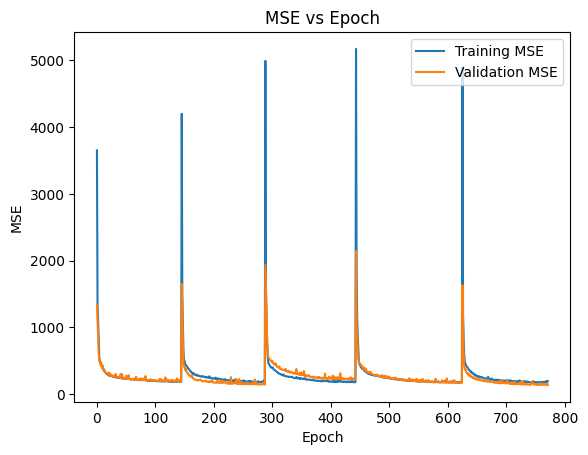

In [119]:
# Show MSE vs Epoch and save plot to file
plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs Epoch')
plt.savefig(os.path.join(ITERATION_FOLDER, "mse_vs_epoch.png"))
plt.show()


2/2 [==============================] - 0s 5ms/step - loss: 109.7025 - mae: 7.8615
MSE: 109.70249938964844
RMSE: 10.473896094083063
MAE: 7.861518859863281
2/2 [==============================] - 0s 2ms/step
(39, 4)


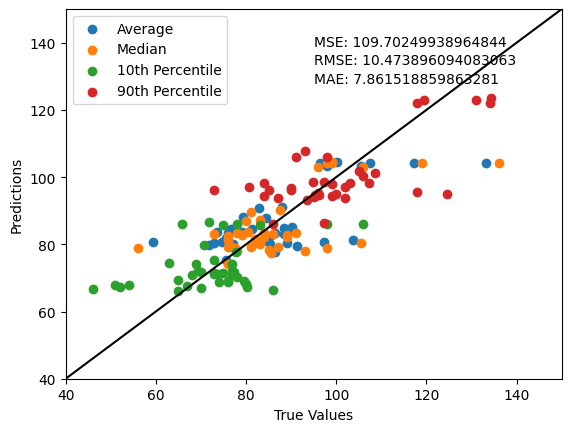

In [120]:
# Test model
TEST_EVALUATION = model.evaluate(X_test, y_test)
print("MSE:", TEST_EVALUATION[0])
print("RMSE:", np.sqrt(TEST_EVALUATION[0]))
print("MAE:", TEST_EVALUATION[1])

# scatter plot for all 4 individual values of the predictions
predictions = model.predict(X_test)

print(predictions.shape)

# Plot
plt.scatter(y_test[:, 0], predictions[:, 0], label="Average")
plt.scatter(y_test[:, 1], predictions[:, 1], label="Median")
plt.scatter(y_test[:, 2], predictions[:, 2], label="10th Percentile")
plt.scatter(y_test[:, 3], predictions[:, 3], label="90th Percentile")

plt.xlabel("True Values")
plt.ylabel("Predictions")

# # Plot x=y for reference
x = np.linspace(0, 200, 100)
y = x

plt.plot(x, y, color="black")

plt.xlim(40, 150)
plt.ylim(40, 150)

# Show MSE, RMSE, MAE
plt.annotate("MSE: {}".format(TEST_EVALUATION[0]), (0.5, 0.9), xycoords='axes fraction')
plt.annotate("RMSE: {}".format(np.sqrt(TEST_EVALUATION[0])), (0.5, 0.85), xycoords='axes fraction')
plt.annotate("MAE: {}".format(TEST_EVALUATION[1]), (0.5, 0.8), xycoords='axes fraction')

plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "scatter_plot.png"))
plt.show()

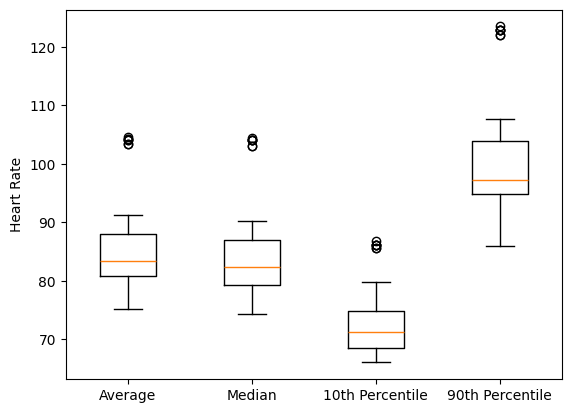

In [121]:
# Show whisker plot of the predictions
plt.boxplot(predictions)
plt.xticks([1, 2, 3, 4], ["Average", "Median", "10th Percentile", "90th Percentile"])
plt.ylabel("Heart Rate")
plt.savefig(os.path.join(ITERATION_FOLDER, "whisker_plot.png"))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


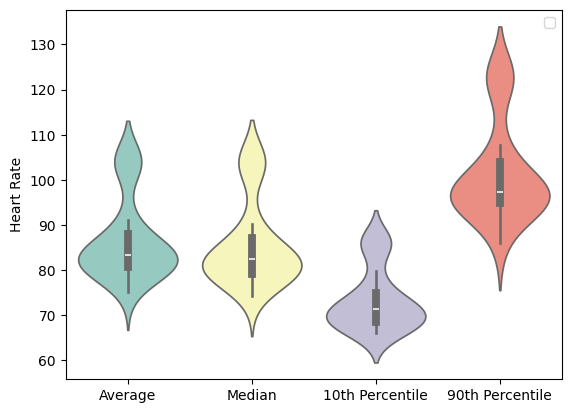

In [122]:
# Show violin plot of the predictions
sns.violinplot(predictions, palette="Set3")
plt.xticks([0, 1, 2, 3], ["Average", "Median", "10th Percentile", "90th Percentile"])
plt.ylabel("Heart Rate")
plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "violin_plot.png"))
plt.show()

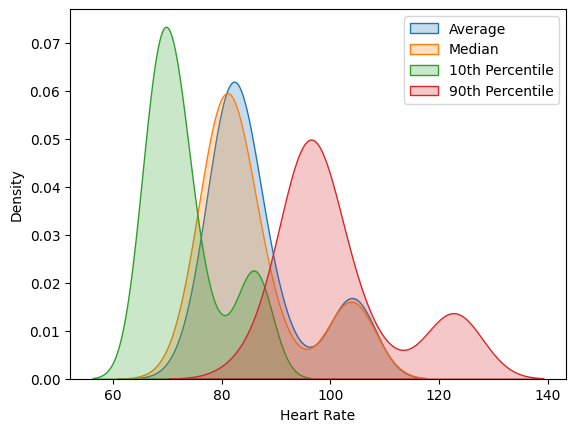

In [123]:
# Show density plot of the predictions and label the densities
sns.kdeplot(predictions[:, 0], fill=True, label="Average")
sns.kdeplot(predictions[:, 1], fill=True, label="Median")
sns.kdeplot(predictions[:, 2], fill=True, label="10th Percentile")
sns.kdeplot(predictions[:, 3], fill=True, label="90th Percentile")
plt.xlabel("Heart Rate")
plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "density_plot.png"))
plt.show()

## Save model to index file

In [124]:
# Make sure index file exists
INDEX_FILE_PATH = os.path.join(MODELS_FOLDER, "index.csv")
if not os.path.exists(INDEX_FILE_PATH):
    with open(INDEX_FILE_PATH, 'w') as f:
        f.write("INDEX, MODEL_NAME, LAYERS, RUN_EPOCHS, BATCH_SIZE, LEARNING_RATE, MSE, RMSE, MAE\n")

# Creates layer string like "32dense-64dense-128dense-10dense"
def get_layer_string(model):
    return "-".join([str(layer.units) + layer.name.split("_")[0] for layer in model.layers])

# Create method for creating short summary string
def get_model_summary(model, epochs, batch_size, lr):
    # Create layer string like "32dense-64dense-128dense-10dense"
    return "{}-e{}-b{}-lr{}".format(get_layer_string(model), epochs, batch_size, lr)

def get_csv_entry(model, epochs, batch_size, lr, mse, rmse, mae):
    return "{},{},{},{},{},{},{},{},{}\n".format(CURRENT_MODEL_ITERATION, model.name, get_layer_string(model), epochs, batch_size, lr, mse, rmse, mae)
    
# Save Entire model
MODEL_FILE_PATH = os.path.join(ITERATION_FOLDER, "model.keras")
model.save(MODEL_FILE_PATH)

# Save model config
MODEL_CONFIG_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_config.json")
with open(MODEL_CONFIG_FILE_PATH, 'w') as f:
    f.write(model.to_json())
    
# Append to index file
with open(INDEX_FILE_PATH, 'a') as f:
    f.write(get_csv_entry(model, RUN_EPOCHS, BATCH_SIZE, LEARNING_RATE, TEST_EVALUATION[0], np.sqrt(TEST_EVALUATION[0]), TEST_EVALUATION[1]))

## Testing model manually

In [125]:
# Print first sample
print (X_test[0])

# Volleybal
sample_vl = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 90, 1, 21, 5]

# Cooking
sample_c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 ,0, 0, 0, 60, 1, 21, 5]

# Meeting
sample_m = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 30, 1, 21, 5]

sample_m_vl = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 60, 1, 8, 1]
sample_m_vl2 = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 60, 1, 21, 1]

# Predict
prediction = model.predict([sample_vl])
print(prediction)

prediction = model.predict([sample_c])
print(prediction)

prediction = model.predict([sample_m])
print(prediction)

prediction = model.predict([sample_m_vl])
print(prediction)
prediction = model.predict([sample_m_vl2])
print(prediction)

tf.Tensor([ 0  0  0  1  0  0  0  0  0  0  0  0  0 90  5 19  2], shape=(17,), dtype=int64)
1/1 [==============================] - 0s 134ms/step
[[104.01125  103.99625   86.057625 122.70067 ]]
1/1 [==============================] - 0s 35ms/step
[[ 87.91371   88.08538   74.07852  101.753204]]
1/1 [==============================] - 0s 45ms/step
[[83.97634 84.17779 75.10059 94.01696]]
1/1 [==============================] - 0s 35ms/step
[[ 91.042274  89.67747   77.885376 106.26179 ]]
1/1 [==============================] - 0s 35ms/step
[[101.50488 101.12446  86.04352 116.94926]]
